# Introduction to WaveNet
## Jonathan Balaban

WaveNet is a powerful new predictive technique that uses multiple Deep Learning (DL) strategies from Computer Vision (CV) and Audio Signal Processing models and applies them to longitudinal (time-series) data. It was created by researchers at London-based artificial intelligence firm DeepMind, and currently powers [Google Assistant voices](https://assistant.google.com).

We'll explore WaveNet and how it works, but first dive into data prep, current high-performance models (as a baseline, Facebook Prophet), and then compare results!

>run this full line in bash, as one line:

`conda create -n wavenet python=3.7 pandas numpy seaborn matplotlib scipy patsy statsmodels jupyter fbprophet`

# Data Setup

In [123]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#pd.core.common.is_list_like = pd.api.types.is_list_like
#from pandas_datareader import data
#from math import sqrt
#import quandl
#quandl.ApiConfig.api_key = "Xe_Akn13ZTp5zvsxoJs7"

In [124]:
# load Apple stock
aapl_raw = pd.read_csv('./AAPL-2000-2019.csv')
#stocks_list = []

# append to empty list
#for symbol in stocks['Symbol']:
    #stocks_list.append(symbol)

In [125]:
aapl_raw.info()

# we need to set date as datetime object and index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4779 entries, 0 to 4778
Data columns (total 7 columns):
Date         4779 non-null object
Open         4779 non-null float64
High         4779 non-null float64
Low          4779 non-null float64
Close        4779 non-null float64
Adj Close    4779 non-null float64
Volume       4779 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 261.4+ KB


In [126]:
aapl_raw.index = pd.to_datetime(aapl_raw.Date)

In [127]:
# check
aapl_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-04-18,2000-04-18,4.410714,4.531250,4.263393,4.531250,3.021451,97731200
2000-04-19,2000-04-19,4.506696,4.651786,4.276786,4.325893,2.884518,130037600
2000-04-20,2000-04-20,4.417411,4.455357,4.180804,4.245536,2.830937,180530000
2000-04-24,2000-04-24,4.107143,4.303571,4.098214,4.303571,2.869634,110905200
2000-04-25,2000-04-25,4.361607,4.598214,4.359375,4.582589,3.055684,97910400


In [128]:
# rename Adj Close to AC, get rid of pesky spacing
aapl_raw['AC'] = aapl_raw['Adj Close']

>Based on [this article](https://finance.zacks.com/adjusted-closing-price-vs-closing-price-9991.html) and others, let's use Adj Close as our series.

In [129]:
# calculate MACD (a key trading metric, and helpful exogenous variable)
aapl_raw['MACD'] = (aapl_raw.AC.ewm(span=12).mean() - aapl_raw.AC.ewm(span=26).mean())

>[MACD is often used by investors as a buy/sell indicator](https://www.investopedia.com/terms/m/macd.asp), so it should help track patterns and trend changes!

In [130]:
# good, now drop Date and everything but AC and Volume
aapl = aapl_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close'])
aapl.head()

,Volume,AC,MACD
Date,,,
2000-04-18,97731200,3.021451,0.000000
2000-04-19,130037600,2.884518,-0.003072
2000-04-20,180530000,2.830937,-0.005576
2000-04-24,110905200,2.869634,-0.005181
2000-04-25,97910400,3.055684,0.002546


In [131]:
aapl.describe().round(2)

,Volume,AC,MACD
count,4.779000e+03,4779.00,4779.00
mean,1.182295e+08,47.69,0.27
std,9.954219e+07,56.83,1.48
min,9.835000e+06,0.62,-10.81
25%,5.056905e+07,3.35,-0.05
50%,9.088870e+07,18.33,0.06
75%,1.547458e+08,87.48,0.54
max,1.855410e+09,230.28,7.16


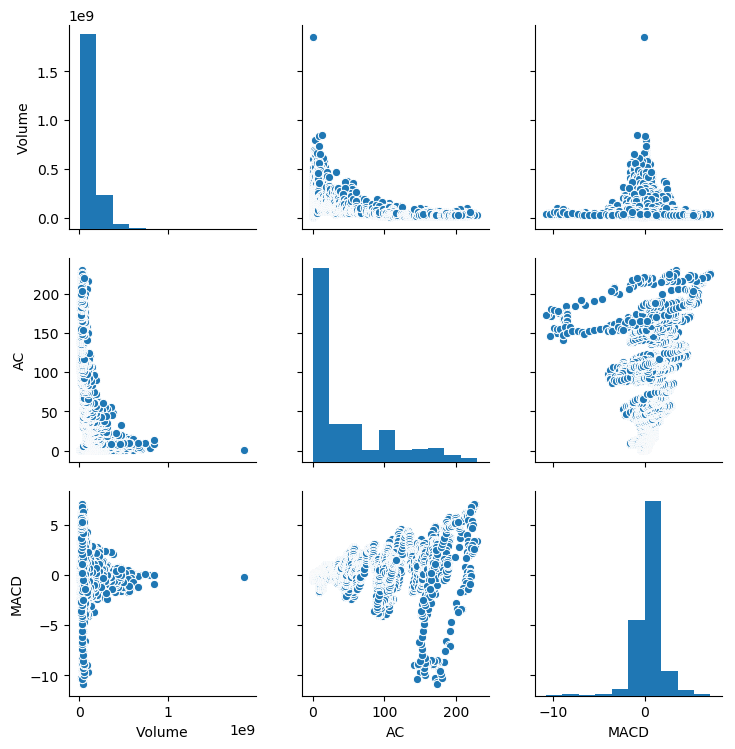

In [132]:
sns.pairplot(aapl);

We can note a few things from the EDA above:
- No NULLs
- Inverse exponential relationship between AC and Volume?
- Right skew in price

There's an important consideration also: **stock splits!**

Apple's stock has split four times since the company went public. The stock split on a 7-for-1 basis on June 9, 2014 and split on a 2-for-1 basis on February 28, 2005, June 21, 2000, and June 16, 1987.

Let's filter to the 2014 and 2005 weeks and see what happened:

In [133]:
# first 2005
#aapl['2005-02-24':'2005-03-02']

# looks like Adj Close accounted for the split automatically

In [134]:
# next 2014
#aapl['2014-06-06':'2014-06-11']

# good again, but essential to check!

## Statistics

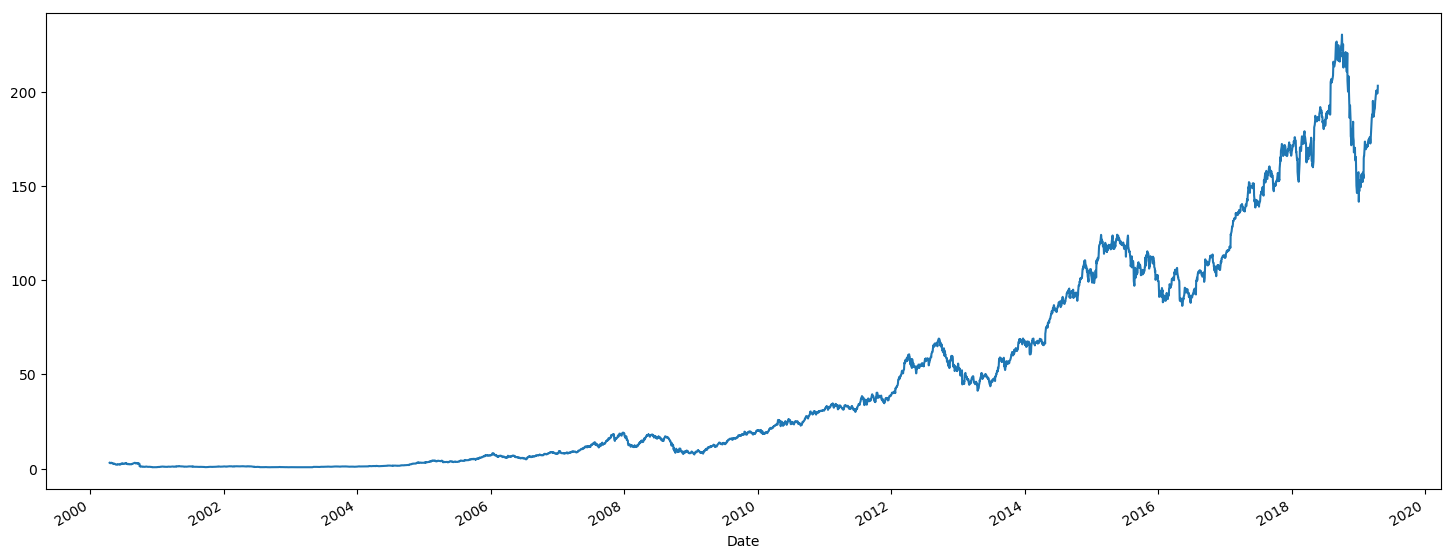

In [135]:
# plot price over time
aapl.AC.plot();

In [136]:
# Optional: run ADF to determine unit root
import statsmodels.tsa.stattools as ts
cadf = ts.adfuller(aapl_raw.AC)

print('Augmented Dickey Fuller:')
print('Test Statistic =',cadf[0])
print('p-value =',cadf[1])
print('Critical Values =',cadf[4])

Augmented Dickey Fuller:
Test Statistic = 1.0742834629100277
p-value = 0.9949910545329405
Critical Values = {'1%': -3.431728601011308, '5%': -2.862149185397661, '10%': -2.567094271358372}


# FB Prophet

In [137]:
from fbprophet import Prophet

# pull only close price and set up dataframe for prophet
aapl_fb = aapl
aapl_fb['ds'] = aapl_fb.index
aapl_fb = aapl_fb.rename(columns={'AC': 'y'})

In [138]:
aapl_fb.head()

,Volume,y,MACD,ds
Date,,,,
2000-04-18,97731200,3.021451,0.000000,2000-04-18
2000-04-19,130037600,2.884518,-0.003072,2000-04-19
2000-04-20,180530000,2.830937,-0.005576,2000-04-20
2000-04-24,110905200,2.869634,-0.005181,2000-04-24
2000-04-25,97910400,3.055684,0.002546,2000-04-25


In [139]:
# fit model without final thirty periods
fbm = Prophet(weekly_seasonality='auto', daily_seasonality=False, seasonality_mode='additive')

fbm.fit(aapl_fb.iloc[:-30,:]);

# create future dataset
future = fbm.make_future_dataframe(periods=30, freq='D')
future.tail()

/Users/jb/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds
4774,2019-04-01
4775,2019-04-02
4776,2019-04-03
4777,2019-04-04
4778,2019-04-05


In [140]:
# check endpoint for train
aapl_fb.iloc[-30,:]

Volume               24760900
y                       172.5
MACD                  2.78684
ds        2019-03-07 00:00:00
Name: 2019-03-07 00:00:00, dtype: object

In [141]:
forecast = fbm.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4774,2019-04-01,193.378753,180.956588,205.728241
4775,2019-04-02,193.432664,181.809206,205.370459
4776,2019-04-03,193.444102,181.002395,205.678995
4777,2019-04-04,193.446699,181.867266,205.259188
4778,2019-04-05,193.390625,181.035125,204.576145


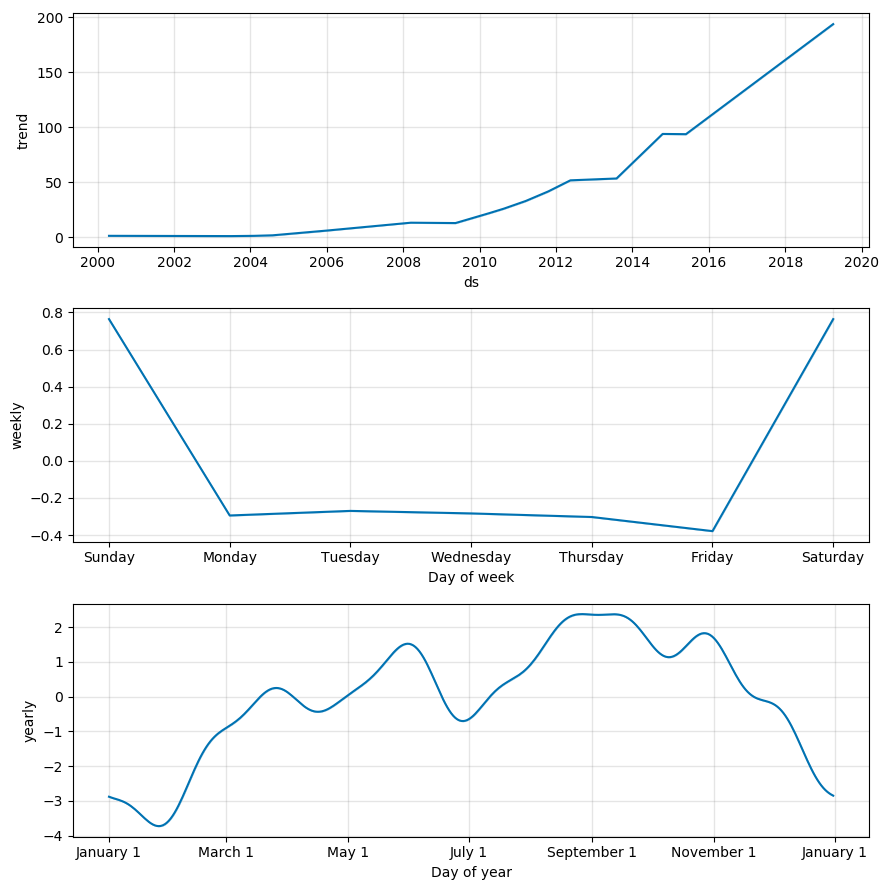

In [142]:
fbm.plot_components(forecast);

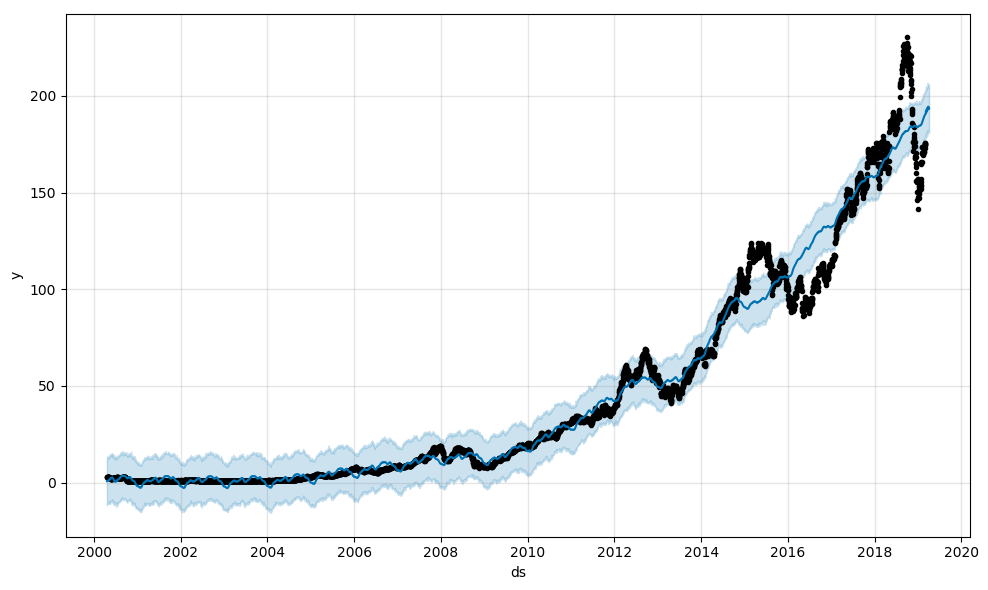

In [143]:
pred_plot = fbm.plot(forecast)

In [144]:
# calculate MAE

diffs = np.absolute(aapl_fb.y[-30:].values - forecast.yhat[-30:].values)

diffs.mean() # this is our metric for comparison

6.146844202636177

# WaveNet

### Dilated Causal Convolution Layers
The model architecture we will build is a variant of the [WaveNet model](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), but optimized for sequence data.

The **dilated causal convolution layer** is the default building block; Joe Eddy has a fantastic breakdown of [how it works here](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb) and [in his blog here](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/). In a nutshell, these layers (borrowed and modified from CNNs) are designed to learn detailed patterns from recent stock price movements, but also big-picture trends and cycles from months and years ago.

![dilated convolutions](./images/WaveNet_dilatedconv.png)

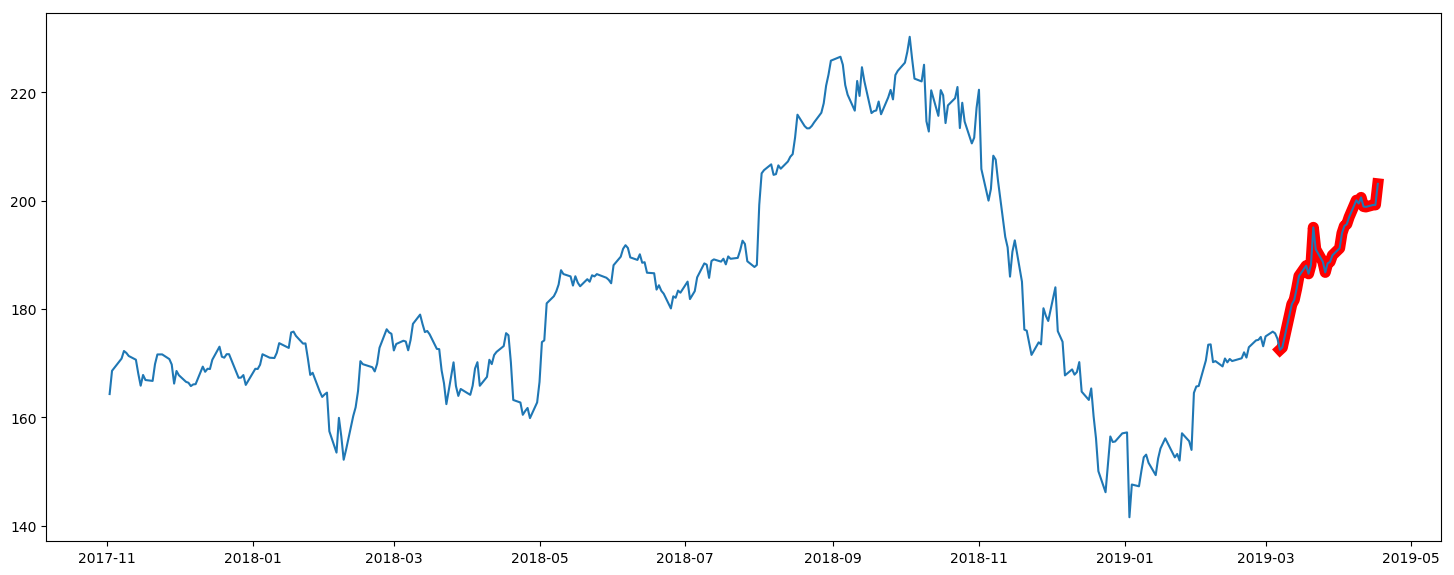

In [180]:
# looking back a month and year
plt.plot(aapl.AC.iloc[-30:], 'r', linewidth=8, markersize=12);
plt.plot(aapl.AC.iloc[-365:]);

# what intel can we gather from each timeframe?

### More building blocks:

We need to add a few other techniques:

![blocks](./images/WaveNet_residblock.png)

### **Gated Activations**

In the boxed portion of the architecture diagram above, note the dilated convolution splits into two branches that recombine via element-wise multiplication. This is a **gated activation unit**:
- **tanh:** activation branch is a learned (model optimized) filter
- **sigmoid:** activation branch is a learned gate that controls flow from the *tanh* filter (just like LSTM gates)

### Skip Connections

In fully-connected NNs, a neuron takes inputs from all neurons in the previous layer: early layers establish later ones via a heirarchy of intermediate computations. This allows NNs to build complex interactions of raw inputs/signals.

But... what if raw inputs are directly useful for prediction, and we want them to directly influence the output? **Skip connections** allow outputs of any layer to bypass multiple future layers and skip influence dilution! Keras allows us to store the tensor output of each convolutional block - in addition to passing it through further layers - with `skips.append()`. Note how for each block in the stack above, the output from the gated activations joins the set of skip connections. How much or how far you do this is a hyper-parameter that depends on your data and model structure!

### Residual Connections

![CNN_skips](./images/CNN_skips.png)

**Residual connections** are similar to skip connections: think of them as consistenly-available short layer skips! We'll use a one-layer skip for our model, but it's also a hyper-parameter. Why they help is mysterious, but it's most likely due to helping with the [Vanishing or Exploding Gradient](https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb) obstacle in backpropagation. This becomes more important with larger models, but I'll show you the implementation in a smaller setting for educational purposes.

> Note: the diagram's *1x1 convolutions* are basically time-distributed fully connected layers; this allows us to use CNN language for our architecting!

![XKCD](./images/XKCD.png)

## Data Setup

First, Keras needs us to convert our series into `numpy` arrays. As we prep our data, we should have a partition strategy to validate and test our model's results. [Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) created a visualization of the **walk-forward validation** strategy that serves as a best practice:

![walk-forward validation](./images/ArturSuilin_validation.png)

>Given our limited time, we'll use a simple train-validation-test set in conjunction with Keras arguments.

In [150]:
#date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
#                          data=[i for i in range(len(df.columns[1:]))])

AC = aapl[aapl.columns[1]].values # converts to numpy

def get_time_block_series(series_array, start_date, end_date):
        return series_array[start_date:end_date]

def transform_series_encode(series_array):
    
    series_array = np.log1p(series_array) # filling NaN with 0
    series_mean = series_array.mean().reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [151]:
transform_series_encode(AC)

(array([[[-1.53304761],
         [-1.56769149],
         [-1.58158097],
         ...,
         [ 2.37477629],
         [ 2.37487619],
         [ 2.39406668]]]), array([[2.9246904]]))

# WaveNet Modeling

## Architecture Overview

Let's build our model like so:

* 16 dilated causal convolutional blocks
    * Pre and postprocessing (time distributed) fully connected layers (i.e. convolutions with filter width 1):
        * 16 output units
    * 32 filters of width 2 per block
    * Exponentially increasing dilation rate with a reset (1, 2, 4, 8,... 2^6), two sets
    * Gated activations
    * Residual and skip connections
* 2 fully connected layers to combine skip outputs to final output 

???
We'll extract the last 60 steps from the output sequence as our predicted output for training. We'll use teacher forcing again during training. Similarly to the previous notebook, we'll have a separate function that runs an inference loop to generate predictions on unseen data, iteratively filling previous predictions into the history sequence (section 4). 

In [152]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

In [153]:
# create architecture and define hyper-parameters
n_filters = 32  
filter_width = 2
dilation_rates = [2**i for i in range(7)] * 2  # two sets, up to 2^6

# structure input series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(1, 1))
x = history_seq

# dynamically create skips per each dilation rate
skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution, notice it looks identical to above?
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f), # tanh turns it into a less "squashed" filter
                    Activation('sigmoid')(x_g)]) # sigmoid turns it into a gate
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(64, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error') # good metric for stock prediction

In [154]:
# print our model architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 1, 16)        32          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_118 (Conv1D)             (None, 1, 32)        1056        conv1d_117[0][0]                 
__________________________________________________________________________________________________
conv1d_119 (Conv1D)             (None, 1, 32)        1056        conv1d_117[0][0]                 
__________________________________________________________________________________________________
activation

In [155]:
# how much data
len(aapl)

4779

In [163]:
# let's train on first half and test on second half

x = np.log(aapl.AC.iloc[:len(aapl)//2+1].values)
y = np.log(aapl.AC.iloc[len(aapl)//2:].values)

x = x.reshape(x.shape[0], 1, 1)
y = y.reshape(y.shape[0], 1, 1)

In [164]:
y

array([[[2.89511615]],

       [[2.94092714]],

       [[2.9714488 ]],

       ...,

       [[5.29445992]],

       [[5.29456032]],

       [[5.31384619]]])

In [167]:
model.compile(Adam(), loss='mean_absolute_error') # Adam will run our backpropogation

results = model.fit(x, y, batch_size=2**6, epochs=50, validation_split=.1)

Train on 2151 samples, validate on 239 samples
Epoch 1/50
2151/2151 [==============================] - 22s 10ms/step - loss: 10.5616 - val_loss: 0.4726
Epoch 2/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.7551 - val_loss: 0.3851
Epoch 3/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.5778 - val_loss: 0.2937
Epoch 4/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.4797 - val_loss: 0.4583
Epoch 5/50
2151/2151 [==============================] - 3s 2ms/step - loss: 0.4488 - val_loss: 0.5377
Epoch 6/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.4166 - val_loss: 0.4522
Epoch 7/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.4088 - val_loss: 0.5037
Epoch 8/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.3961 - val_loss: 0.4476
Epoch 9/50
2151/2151 [==============================] - 3s 1ms/step - loss: 0.4020 - val_loss: 0.4517
Epoch 10/50
2151/2151 [=========

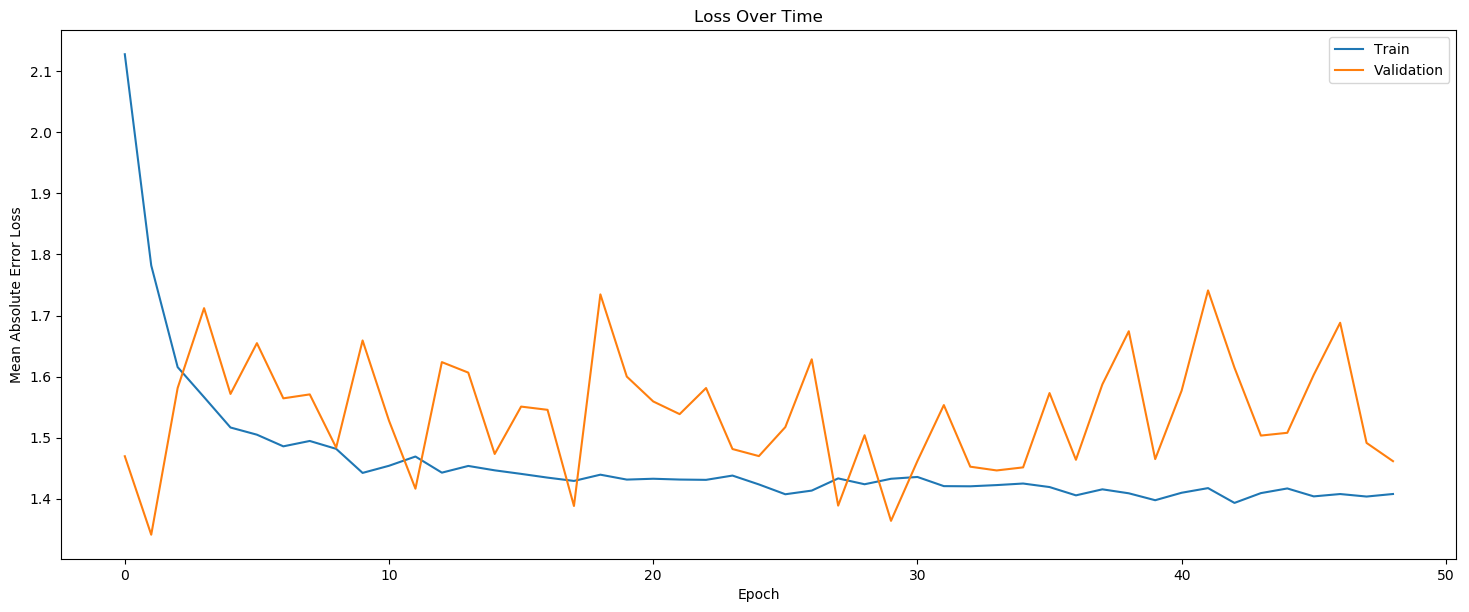

In [173]:
plt.plot(np.exp(results.history['loss'][1:]))
plt.plot(np.exp(results.history['val_loss'][1:]))

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.legend(['Train','Validation'])
plt.title('Loss Over Time');

# Additional Resources

Many thanks to my amazing colleague [Joe Eddy]() for his informative blog posts on WaveNet (which inspired me to explore the architecture):
- [Time Series Forecasting with Convolutional Neural Networks - a Look at WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/)
- [Time Series Forecasting with Convolutional Neural Networks - Further Exploration of WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/)
- Optional context: [Forecasting with Neural Networks - An Introduction to Sequence-to-Sequence Modeling Of Time Series](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/)


## WaveNet Official
- [Blog on audio applications](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)
- [Voice showcase](https://cloud.google.com/text-to-speech/docs/wavenet)
- [Paper](https://arxiv.org/abs/1609.03499)
- [Wiki](https://en.wikipedia.org/wiki/WaveNet)